# A CCN Model for Binary (Tumor/Normal) Classification of MR Brain Images
Hamidreza Rashidy Kanan  
June 2022


## 1. Install Required Libraries

In [1]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


## 2. Import Required Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from PIL import Image

## 3. Dataset Generation

The images are loaded from the current working directory to create the whole dataset which is further partioned to the Train, Validation and Test datasets.
We used 80% of the images for model training, 10% for model validation and 10% for model test.

In [4]:
# To see the image content
# im = Image.open('Data/slices_with_tumor_label_1/BraTS20_Training_001_t1_rlp_0.0_label_1.jpeg', 'r')
# pix_val = list(im.getdata())
# print(pix_val)

slices_with_tumor_label_1 = glob.glob('Data/slices_with_tumor_label_1/*.*')
slices_without_tumor_label_0 = glob.glob('Data/slices_without_tumor_label_0/*.*')

data = []
labels = []

for i in slices_with_tumor_label_1:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (240,240))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in slices_without_tumor_label_0:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (240,240))
    image=np.array(image)
    data.append(image)
    labels.append(0)


data = np.array(data)
labels = np.array(labels)

print (data.shape)
print (labels.shape)


# Let's say we want to split the data in 80:10:10 for train:valid:test dataset

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(data, labels, train_size=0.8, shuffle = True, random_state=1)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, shuffle = True, random_state=1)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(41654, 240, 240)
(41654,)
(33323, 240, 240)
(33323,)
(4165, 240, 240)
(4165,)
(4166, 240, 240)
(4166,)


(None, None)

## 4. Data Visualization
Here are the first six images from the training set with their lables:

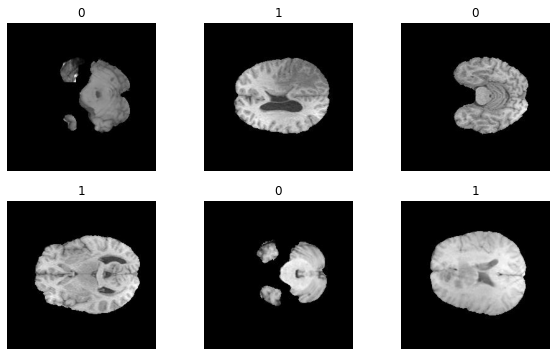

In [5]:
plt.figure(figsize=(10, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(np.reshape(X_train[i],(240,240)),'gray')
    plt.title(Y_train[i])
    plt.axis("off")

## 5. Model Creation

A sequential model consisting four convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them is used. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). Finally, since the goal is to perform binary classification, the sigmoid activation function is used at final layer.
In oredr to reduce the overfitting, the dropout regularization is also utilized between the layers.

In [6]:
num_classes = 2
img_height = 240
img_width = 240

model = Sequential([  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

2022-07-16 00:46:52.584502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 6. Model Summary

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 240, 240, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

## 7. Compile and Train the Model
The (tf.keras.optimizers.Adam) optimizer and (tf.keras.losses.binary_Crossentropy) loss function are used at this step for compiling the model, and then the model is trained using the training dataset.

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.AUC(curve="ROC"),'accuracy'])

epochs = 10
history = model.fit(
  X_train, Y_train,
  validation_data=(X_valid,Y_valid),
  epochs=epochs
)

2022-07-16 00:46:52.743849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1042/1042 [==============================] - 820s 786ms/step - loss: 0.4812 - auc: 0.8390 - accuracy: 0.7685 - val_loss: 0.4541 - val_auc: 0.8589 - val_accuracy: 0.7794
Epoch 2/10
1042/1042 [==============================] - 823s 789ms/step - loss: 0.4339 - auc: 0.8732 - accuracy: 0.7892 - val_loss: 0.3918 - val_auc: 0.9027 - val_accuracy: 0.8108
Epoch 3/10
1042/1042 [==============================] - 837s 803ms/step - loss: 0.3644 - auc: 0.9147 - accuracy: 0.8297 - val_loss: 0.3275 - val_auc: 0.9425 - val_accuracy: 0.8615
Epoch 4/10
1042/1042 [==============================] - 838s 804ms/step - loss: 0.2918 - auc: 0.9466 - accuracy: 0.8684 - val_loss: 0.2546 - val_auc: 0.9607 - val_accuracy: 0.8946
Epoch 5/10
1042/1042 [==============================] - 832s 799ms/step - loss: 0.2291 - auc: 0.9674 - accuracy: 0.9009 - val_loss: 0.1989 - val_auc: 0.9767 - val_accuracy: 0.9232
Epoch 6/10
1042/1042 [==============================] - 832s 799ms/step - loss: 0.1777 - auc: 0.9803

## 8. Model Evaluation (Accuracy, Loss and AUC-ROC)

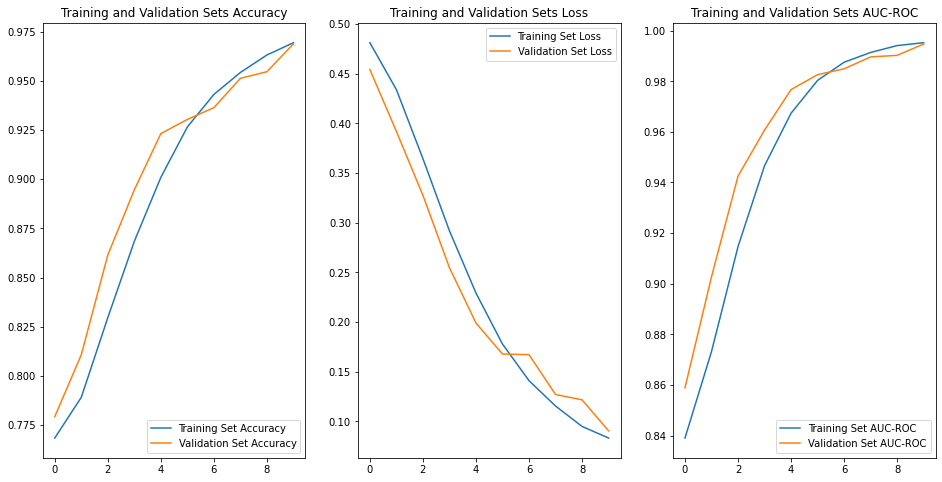

In [9]:
epochs_range = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Set Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Set Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Sets Accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Set Loss')
plt.plot(epochs_range, val_loss, label='Validation Set Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Sets Loss')

auc_ROC = history.history['auc']
val_auc = history.history['val_auc']
plt.subplot(1, 3, 3)
plt.plot(epochs_range, auc_ROC, label='Training Set AUC-ROC')
plt.plot(epochs_range, val_auc, label='Validation Set AUC-ROC')
plt.legend(loc='lower right')
plt.title('Training and Validation Sets AUC-ROC')
plt.show()

## 9. Visualizing the ROC and the Precision-Recall Curves
The validation dataset is used to evaluate the model performance, and then the result is visualized using both ROC and precision-recall curves.

131/131 [==============================] - 27s 209ms/step


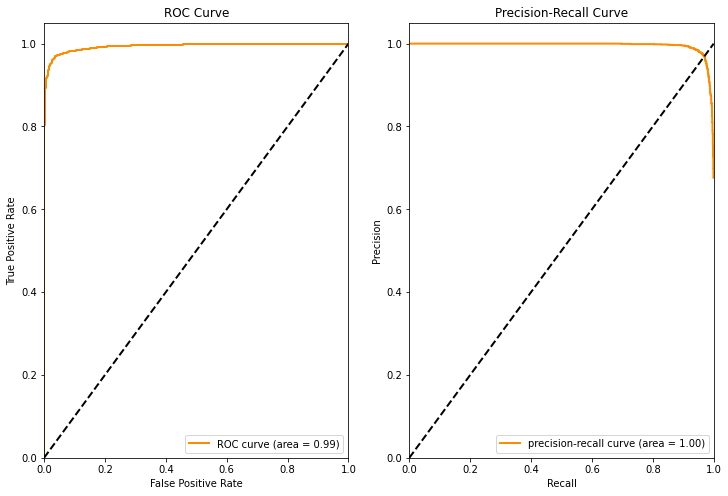

In [10]:
val_preds = model.predict(X_test, verbose=1).ravel()
fpr, tpr, thresholds = roc_curve(Y_test, val_preds)
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

precision, recall, thresholds = precision_recall_curve(Y_test, val_preds)
pr_auc = auc(recall, precision)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange',
lw=2, label='precision-recall curve (area = %0.2f)' % pr_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()